# Evaluates our Base Model
I have not implemented a test set yet so this uses the validation set
and just generates some basic stats and pictures 

In [26]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

import sys
sys.path.append("..")

from modelUtils import loadCheckpoint, plotPredVsTrue
from dataUtils import loadEnergyData, processData, energyDataset, getDatasets, normalizeAdjMat
from models.baseSTGCN import STGCN

In [30]:
# params
torch.manual_seed(0)
np.random.seed(0)

num_features = 12
historical_input = 48
forecast_output = 24

validation_range = ["2014-10-01 00:00:00", "2014-12-31 23:00:00"]
validation_range = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in validation_range]


args = {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "epochs": 200,
        "batch_size": 32,
        "lr": .001
}

processed_dir = "../data/processed/"

# loss functions to compute
mae_criterion = nn.L1Loss()
mse_criterion = nn.MSELoss()

In [28]:
# Get validation data
energy_demand, adj_mat = loadEnergyData(processed_dir, incl_nodes = 100, partial = False)
train_dataset, val_dataset = getDatasets(energy_demand, validation_range,
                                         historical_input, forecast_output)

val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)


# normalized adjacency matrix with self loop
adj_norm = normalizeAdjMat(adj_mat)
adj_norm = adj_norm.to(args['device']) 

In [25]:
# Model init
num_nodes = len(energy_demand.node.unique())

Gnet = STGCN(num_nodes,
             num_features,
             historical_input,
             forecast_output).to(device=args['device'])

model = loadCheckpoint(Gnet, filename = "initial model.pth", folder = '../savedModels/checkpoint')
model

STGCN(
  (block1): spatioTemporalBlock(
    (t1): temporalConv(
      (conv1): Conv2d(12, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(12, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (t2): temporalConv(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): spatioTemporalBlock(
    (t1): temporalConv(
      (conv1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (t2): temporalConv(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (final_temporal): temporalConv(
    (conv1): Conv2d(64, 64, kernel_size=(1, 3),

In [33]:
# Get Predictions
val_predictions = []
val_target = []

mae_list = []
mse_list = []
rmse_list = []

with torch.no_grad():
    Gnet.eval()
    for vbatch_idx, (vfeatures, vtarget) in enumerate(val_loader):
        vfeatures = vfeatures.to(args['device'])
        vtarget = vtarget.to(args['device'])

        # predict 
        vpreds = Gnet(vfeatures, adj_norm)
        mse_loss = mse_criterion(vpreds, vtarget)
        mae_loss = mae_criterion(vpreds, vtarget)
        rmse_loss = torch.sqrt(mse_criterion(vpreds, vtarget))

        # storage and tracking
        mse_list.append(mse_loss.detach().cpu().numpy())
        mae_list.append(mae_loss.detach().cpu().numpy())
        rmse_list.append(rmse_loss.detach().cpu().numpy())
        
        # store preds and target in correct order
        np_vpreds = vpreds.detach().cpu().numpy()
        np_vtarget = vtarget.detach().cpu().numpy()
        val_predictions.append(np_vpreds)
        val_target.append(np_vtarget)
        
val_predictions = np.concatenate(val_predictions)
val_target = np.concatenate(val_target)

mae = np.mean(mae_list)
mse = np.mean(mse_list)
rmse = np.mean(rmse_list)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.1668127030134201
Mean Squared Error: 0.04526595398783684
Root Mean Squared Error: 0.21275730431079865


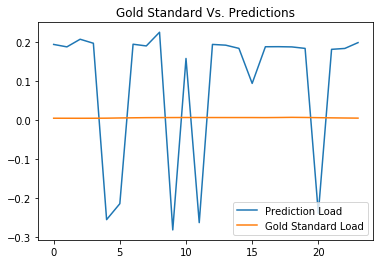

In [34]:
plotPredVsTrue(val_target, val_predictions, 18, 3)

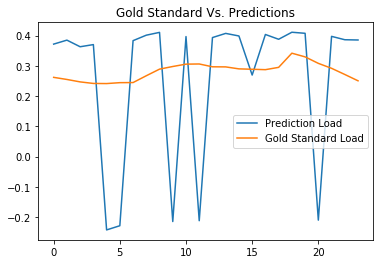

In [38]:
plotPredVsTrue(val_target, val_predictions, 1, 1)

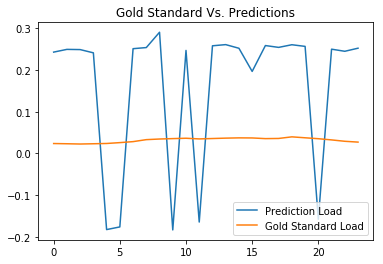

In [37]:
plotPredVsTrue(val_target, val_predictions, 10, 8)